In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
from torchvision import datasets, transforms

veriDizini = '/content/drive/My Drive/YapayZekaRessam'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

egitimSeti = datasets.ImageFolder(os.path.join(veriDizini, 'train'), transform=transform)
egitimYukleyici = torch.utils.data.DataLoader(egitimSeti, batch_size=batch_size, shuffle=True, num_workers=4)

dogrulamaSeti = datasets.ImageFolder(os.path.join(veriDizini, 'val'), transform=transform)
dogrulamaYukleyici = torch.utils.data.DataLoader(dogrulamaSeti, batch_size=batch_size, shuffle=False, num_workers=4)

testSeti = datasets.ImageFolder(os.path.join(veriDizini, 'test'), transform=transform)
testYukleyici = torch.utils.data.DataLoader(testSeti, batch_size=batch_size, shuffle=False, num_workers=4)

yukleyiciler = {
    'train': egitimYukleyici,
    'val': dogrulamaYukleyici,
    'test': testYukleyici,
}

veriSetiBoyutlari = {
    'train': len(egitimSeti),
    'val': len(dogrulamaSeti),
    'test': len(testSeti)
}

siniflar = egitimSeti.classes
print(f"Veri seti başarıyla yüklendi ve hazırlandı. Sınıflar: {siniflar}")


Veri seti başarıyla yüklendi ve hazırlandı. Sınıflar: ['Eyvind Earle420_artırılmış', 'Henri Matisse420_artırılmış', 'HenriMartin420_artırılmış', 'MarcChagall_420_artırılmış', 'Monet420_artırılmış', 'picasso_aug', 'pierre_aug', 'rembrandt_aug', 'salvador_aug', 'vangogh_aug']


In [3]:
import torch
import torch.nn as nn
from timm import create_model

cihaz = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('pit_b_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 10)
model = model.to(cihaz)

print('Pit base modeli oluşturuldu ve GPU\'ya yüklendi.')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/295M [00:00<?, ?B/s]

Pit base modeli oluşturuldu ve GPU'ya yüklendi.


In [4]:
from transformers import AutoFeatureExtractor, BeitForImageClassification
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import time

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [6]:
num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start_time = time.time()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

def train_epoch(model, yukleyiciler, veriSetiBoyutlari, optimizer, criterion, cihaz):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(yukleyiciler['train']):
        inputs = inputs.to(cihaz)
        labels = labels.to(cihaz)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if (i + 1) % 10 == 0:
            batch_accuracy = torch.sum(preds == labels.data).item() / labels.size(0)
            print(f'Batch {i+1}/{len(yukleyiciler["train"])}: Train Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy*100:.2f}%')

    epoch_loss = running_loss / veriSetiBoyutlari['train']
    epoch_acc = running_corrects.double() / veriSetiBoyutlari['train'] * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch Train Loss: {epoch_loss:.4f}, Epoch Train Accuracy: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc

def validate_epoch(model, yukleyiciler, veriSetiBoyutlari, criterion, cihaz):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(yukleyiciler['val']):
        inputs = inputs.to(cihaz)
        labels = labels.to(cihaz)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if (i + 1) % 10 == 0:
            batch_accuracy = torch.sum(preds == labels.data).item() / labels.size(0)
            print(f'Batch {i+1}/{len(yukleyiciler["val"])}: Val Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy*100:.2f}%')

    epoch_loss = running_loss / veriSetiBoyutlari['val']
    epoch_acc = running_corrects.double() / veriSetiBoyutlari['val'] * 100

    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)

    print(f'Epoch Val Loss: {epoch_loss:.4f}, Epoch Val Accuracy: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    print('-' * 10)

    train_loss, train_acc = train_epoch(model, yukleyiciler, veriSetiBoyutlari, optimizer, criterion, cihaz)
    val_loss, val_acc = validate_epoch(model, yukleyiciler, veriSetiBoyutlari, criterion, cihaz)

training_time = time.time() - start_time
print(f'Total Training Time: {training_time:.2f} seconds')
print('Eğitim tamamlandı')

Epoch 1/2
----------
Batch 10/425: Train Loss: 1.1474, Batch Accuracy: 71.09%
Batch 20/425: Train Loss: 0.5329, Batch Accuracy: 82.03%
Batch 30/425: Train Loss: 0.4024, Batch Accuracy: 85.16%
Batch 40/425: Train Loss: 0.3357, Batch Accuracy: 88.28%
Batch 50/425: Train Loss: 0.3628, Batch Accuracy: 89.84%
Batch 60/425: Train Loss: 0.2123, Batch Accuracy: 92.19%
Batch 70/425: Train Loss: 0.1902, Batch Accuracy: 95.31%
Batch 80/425: Train Loss: 0.1992, Batch Accuracy: 94.53%
Batch 90/425: Train Loss: 0.2002, Batch Accuracy: 93.75%
Batch 100/425: Train Loss: 0.2004, Batch Accuracy: 95.31%
Batch 110/425: Train Loss: 0.1247, Batch Accuracy: 96.88%
Batch 120/425: Train Loss: 0.0951, Batch Accuracy: 96.88%
Batch 130/425: Train Loss: 0.1189, Batch Accuracy: 96.88%
Batch 140/425: Train Loss: 0.0599, Batch Accuracy: 99.22%
Batch 150/425: Train Loss: 0.0348, Batch Accuracy: 99.22%
Batch 160/425: Train Loss: 0.0353, Batch Accuracy: 98.44%
Batch 170/425: Train Loss: 0.0328, Batch Accuracy: 99.22%
Ba

In [15]:
import torch

model_dosya_yolu = '/content/drive/My Drive/colabmodels/pit_models_son.h5'
torch.save(model.state_dict(), model_dosya_yolu)
print(f'Model başarıyla {model_dosya_yolu} yoluna kaydedildi.')

Model başarıyla /content/drive/My Drive/colabmodels/pit_models_son.h5 yoluna kaydedildi.


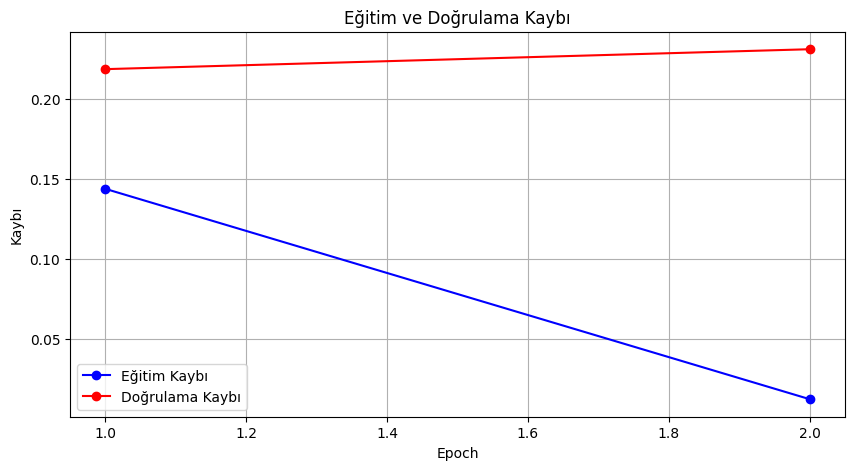

In [12]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'bo-', label='Eğitim Kaybı')
    plt.plot(epochs, val_losses, 'ro-', label='Doğrulama Kaybı')
    plt.title('Eğitim ve Doğrulama Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kaybı')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

In [9]:
gercek = []
tahmin = []

model.eval()
with torch.no_grad():
    for inputs, labels in testYukleyici:
        inputs, labels = inputs.to(cihaz), labels.to(cihaz)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        gercek.extend(labels.cpu().numpy())
        tahmin.extend(predicted.cpu().numpy())

confMatrix = confusion_matrix(gercek, tahmin)

def hesaplaSpecificity(confMatrix):
    specificitySinifBasina = []
    for i in range(len(confMatrix)):
        tn = confMatrix.sum() - (confMatrix[i, :].sum() + confMatrix[:, i].sum() - confMatrix[i, i])
        fp = confMatrix[:, i].sum() - confMatrix[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificitySinifBasina.append(specificity)
    return np.mean(specificitySinifBasina)

specificity = hesaplaSpecificity(confMatrix)

accuracy = accuracy_score(gercek, tahmin)
precision = precision_score(gercek, tahmin, average='weighted')
recall = recall_score(gercek, tahmin, average='weighted')
fScore = f1_score(gercek, tahmin, average='weighted')

olasilik = []
with torch.no_grad():
    for inputs, _ in testYukleyici:
        inputs = inputs.to(cihaz)
        outputs = model(inputs)
        olasiliklar = torch.softmax(outputs, dim=1)
        olasilik.extend(olasiliklar.cpu().numpy())

gercekOneHot = np.eye(len(np.unique(gercek)))[gercek]
auc = roc_auc_score(gercekOneHot, np.array(olasilik), average='weighted', multi_class='ovr')

print(f"Accuracy: %{accuracy * 100:.2f}")
print(f"Precision: %{precision * 100:.2f}")
print(f"Recall: %{recall * 100:.2f}")
print(f"Specificity: %{specificity * 100:.2f}")
print(f"F-Score: %{fScore * 100:.2f}")
print(f"AUC: %{auc * 100:.2f}")

Accuracy: %95.20
Precision: %95.41
Recall: %95.20
Specificity: %99.47
F-Score: %95.21
AUC: %99.74


In [10]:
import time

def cikarimHesap(model, testYukleyici, cihaz):
    model.eval()
    baslangicZamani = time.time()

    with torch.no_grad():
        for gorseller, _ in testYukleyici:
            gorseller = gorseller.to(cihaz)
            cikti = model(gorseller)

    bitisZamani = time.time()
    cikarmaZamani = bitisZamani - baslangicZamani
    return cikarmaZamani

cikarmaZamani = cikarimHesap(model, testYukleyici, cihaz)
print(f'Çıkarım Zamanı: {cikarmaZamani:.2f} saniye')

Çıkarım Zamanı: 5.25 saniye


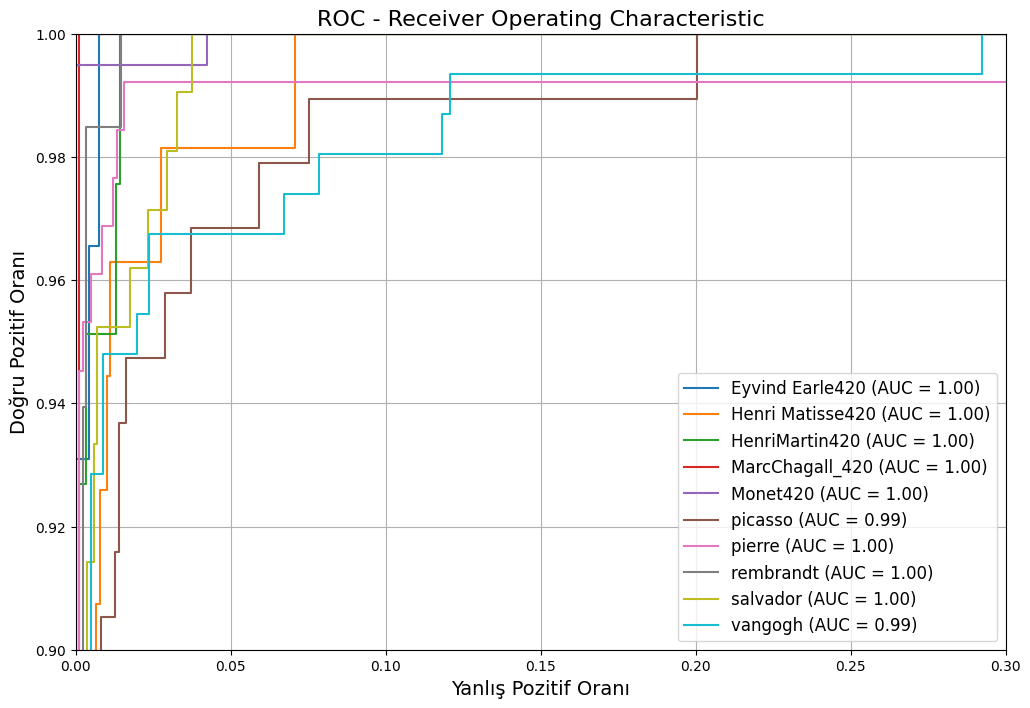

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def ROCEgrisi(gercek, olasilik, sinifAdlari):
    plt.figure(figsize=(12, 8))

    for i, sinifAdi in enumerate(sinifAdlari):
        fpr, tpr, _ = roc_curve(gercek[:, i], olasilik[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{sinifAdi} (AUC = {roc_auc:.2f})')

    plt.xlim([0.0, 0.3])
    plt.ylim([0.9, 1.0])
    plt.xlabel('Yanlış Pozitif Oranı', fontsize=14)
    plt.ylabel('Doğru Pozitif Oranı', fontsize=14)
    plt.title('ROC - Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc='lower right', prop={'size': 12})
    plt.grid(True)
    plt.show()

gercek = []
olasilik = []

model.eval()
with torch.no_grad():
    for inputs, labels in testYukleyici:
        inputs, labels = inputs.to(cihaz), labels.to(cihaz)
        outputs = model(inputs)
        olasiliklar = torch.softmax(outputs, dim=1)

        gercek.extend(labels.cpu().numpy())
        olasilik.extend(olasiliklar.cpu().numpy())

gercekOneHot = np.eye(len(np.unique(gercek)))[gercek]
olasilik = np.array(olasilik)

sinifAdlari = testSeti.classes

ROCEgrisi(gercekOneHot, olasilik, sinifAdlari)

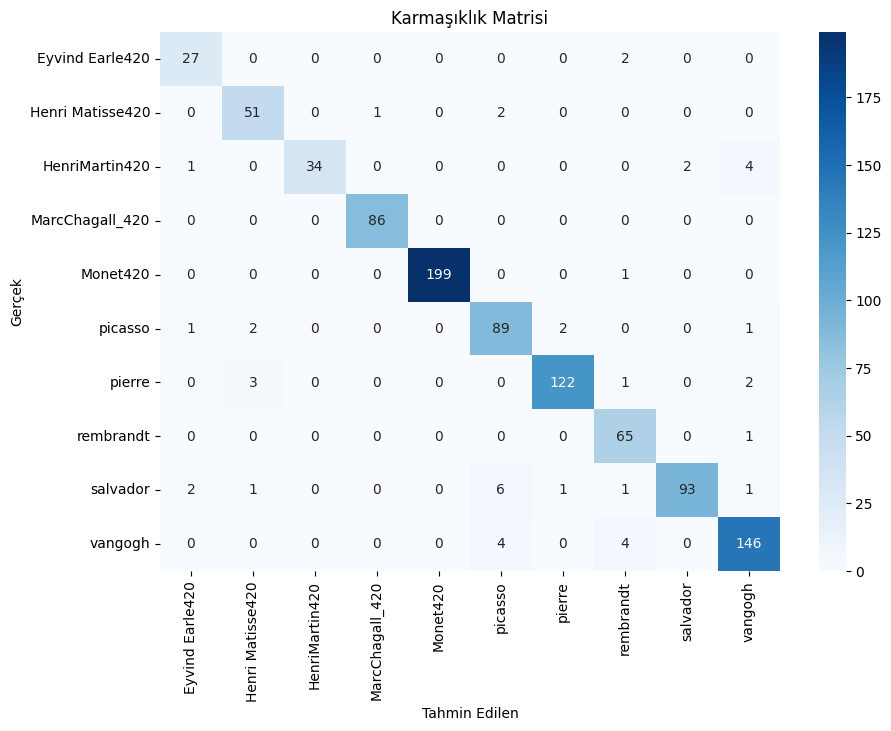

In [14]:
import seaborn as sns

def karmasiklikMatris(gercek, tahmin, sinifAdlari):
    confMatrix = confusion_matrix(gercek, tahmin)

    plt.figure(figsize=(10, 7))
    sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=sinifAdlari, yticklabels=sinifAdlari)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title('Karmaşıklık Matrisi')
    plt.show()

gercek = []
tahmin = []

model.eval()
with torch.no_grad():
    for inputs, labels in testYukleyici:
        inputs, labels = inputs.to(cihaz), labels.to(cihaz)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        gercek.extend(labels.cpu().numpy())
        tahmin.extend(predicted.cpu().numpy())

sinifAdlari = testSeti.classes

karmasiklikMatris(gercek, tahmin, sinifAdlari)